### YouTube Sentiment Analysis - Be Kind Rewind

#### 1. Introduction and objectives

##### 1.1 Introduction
I've always been fascinated by women in films and the real women who play them. Every year I try to see who are nominated for the top acting prize for women and I make sure to watch the performances that garnered them that nomination. I would also often search for videos of past winners and watch their acceptance speeches and to also see which exceptional actresses they were able to beat. So I was very glad to discover this YouTube channel called Be Kind Rewind. The channel is mainly about past best actress winners, women in film, and film and Hollywood history.The videos delve into the career of these accomplished women and the circumstances that lead to their win. The videos are well-researched and very insightful. I love history, I love film, and I love women in film so I trully enjoy every video from this channel. And so, I wanted to see what other people thought about this channel and its videos. In this project, I apply natural language processing (NLP) to determine the general sentiments on this channel. The results of this project will provide the creator behind this Youtube channel a good idea of how viewers perceive the content produced.

##### 1.2 Objectives
The goals of this project are:
- Use the YouTube API to collect the data for this project
- Determine the polarity of sentiments in the video comments using NLP
- Get the most common words used in comments

##### 1.3 Steps
- Download channel, video, and comments data from YouTube using the YouTube API
- Clean and preprocess the data
- Perform exploratory data analysis (EDA) on the data
- Analyse the sentiment of all the comments on the videos and the channel as a whole
- Conclusion

##### 1.4 The Data
The data was scraped using Google Youtube Data API version 3.0. There are two datasets: one for the details for each of the 67 videos on the channel and one for the comments posted for all of the videos on the channel. The first dataset was used to analyze the overall performance of the channel. The second dataset was used to get the sentiments from viewers. 

##### Import relevelant packages 

In [1]:
import config #contains my API credentials
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from IPython.display import JSON
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import demoji
import nltk
from nltk.corpus import stopwords
from textblob import Word, TextBlob

#### 2. Data Extraction with YouTube API

##### Define functions to get data from YouTube

In [2]:
def get_channel_stats(youtube, channel_ids):
    #Function to get the channel statistics as well as the playlistID for the channel
    all_data=[]
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()
    
    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers':item['statistics']['subscriberCount'],
                'views':item['statistics']['viewCount'],
                'totalVideos':item['statistics']['videoCount'],
                'playlistID':item['contentDetails']['relatedPlaylists']['uploads']
               }
        all_data.append(data)
    return(pd.DataFrame(all_data))

In [3]:
def get_video_ids(youtube, playlist_id):
    #get the video IDs of all the videos of the channel included in the playlistID
    video_ids=[]
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50)
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token)
        response = request.execute()
    
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
            
        next_page_token = response.get('nextPageToken')
    return video_ids

In [4]:
def get_video_details(youtube, video_ids):
    #get various information about the the videos of the channel such as viewCount, likeCount, commentCount, etc.
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [5]:
def get_video_comments(youtube, video_ids):
    #get all the commments for a list of video IDs
    all_comments = pd.DataFrame(columns=(['video_id','authorDisplayName','publishedAt','comments','likeCount']))
        
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id,
                maxResults=100)
            response = request.execute()

            comm_counter = 0
            comments_in_video_info = pd.DataFrame(columns=(['video_id','authorDisplayName','publishedAt','comments','likeCount']))
            for comment in response['items']:
                comment_temp = comment['snippet']['topLevelComment']['snippet']['textOriginal']
                publishedAt_temp = comment['snippet']['topLevelComment']['snippet']['publishedAt']
                authorDisplayName_temp = comment['snippet']['topLevelComment']['snippet']['authorDisplayName']
                likeCount_temp = comment['snippet']['topLevelComment']['snippet']['likeCount']
                comments_in_video_info = comments_in_video_info.append({'video_id': video_id, 
                                                                        'comments':comment_temp, 
                                                                        'publishedAt':publishedAt_temp, 
                                                                        'authorDisplayName':authorDisplayName_temp,
                                                                        'likeCount':likeCount_temp},ignore_index=True)
                if comment['snippet']['totalReplyCount'] !=0:
                    try:
                        for reply in comment['replies']['comments']:
                            comment_temp = reply['snippet']['textOriginal']
                            publishedAt_temp = reply['snippet']['publishedAt']
                            authorDisplayName_temp = reply['snippet']['authorDisplayName']
                            likeCount_temp = reply['snippet']['likeCount']
                            comments_in_video_info = comments_in_video_info.append({'video_id': video_id, 
                                                                                    'comments':comment_temp, 
                                                                                    'publishedAt':publishedAt_temp, 
                                                                                    'authorDisplayName':authorDisplayName_temp,
                                                                                    'likeCount':likeCount_temp},ignore_index=True)
                    except:
                        # When error occurs - totalReplyCount is not 0 but there are no replies
                        print('Could not get reply for comment ' + str(comm_counter) + " for video "+ str(video_id))
                comm_counter += 1

            next_page_token = response.get('nextPageToken')
            while next_page_token is not None:
                request = youtube.commentThreads().list(
                    part="snippet,replies",
                    videoId=video_id,
                    maxResults=100,
                    pageToken = next_page_token)
                response = request.execute()

                for comment in response['items']:
                    comment_temp = comment['snippet']['topLevelComment']['snippet']['textOriginal']
                    publishedAt_temp = comment['snippet']['topLevelComment']['snippet']['publishedAt']
                    authorDisplayName_temp = comment['snippet']['topLevelComment']['snippet']['authorDisplayName']
                    likeCount_temp = comment['snippet']['topLevelComment']['snippet']['likeCount']
                    comments_in_video_info = comments_in_video_info.append({'video_id': video_id, 
                                                                            'comments':comment_temp, 
                                                                            'publishedAt':publishedAt_temp, 
                                                                            'authorDisplayName':authorDisplayName_temp,
                                                                            'likeCount':likeCount_temp},ignore_index=True)
                    if comment['snippet']['totalReplyCount'] !=0:
                        try:
                            for reply in comment['replies']['comments']:
                                comment_temp = reply['snippet']['textOriginal']
                                publishedAt_temp = reply['snippet']['publishedAt']
                                authorDisplayName_temp = reply['snippet']['authorDisplayName']
                                likeCount_temp = reply['snippet']['likeCount']
                                comments_in_video_info = comments_in_video_info.append({'video_id': video_id, 
                                                                                        'comments':comment_temp, 
                                                                                        'publishedAt':publishedAt_temp, 
                                                                                        'authorDisplayName':authorDisplayName_temp,
                                                                                        'likeCount':likeCount_temp},ignore_index=True)
                        except:
                            # When error occurs - totalReplyCount is not 0 but there are no replies
                            print('Could not get reply for comment ' + str(comm_counter) + " for video "+ str(video_id))
                    comm_counter += 1

                next_page_token = response.get('nextPageToken')
            all_comments = pd.concat([all_comments, comments_in_video_info],ignore_index=True)  
            
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return all_comments     

In [6]:
def count_video_comments(youtube,video_id):
    #count the comments extracted versus the comments expected
    comment_counter = 0 #number of comments as per video statistics
    top_comments_count = 0 #actual number of top-level comments retrieved/counted
    reply_count_info = 0 #number of replies as per top-level comment snippet
    reply_counted = 0 #actual number of replies retrieved/counted
    comm_counter = 0 
    
    request = youtube.commentThreads().list(
        part="snippet,replies",
        videoId=video_id,
        order='time',
        maxResults=100)
    response = request.execute()
    
    request2 = youtube.videos().list(
        part="statistics",
        id=video_id)
    response2 = request2.execute()
    
    for video in response2['items']:
        comment_counter += int(video['statistics']['commentCount']) 
    
    top_comments_count += len(response['items'])
    
    for comment in response['items']:
        reply_count_info += comment['snippet']['totalReplyCount']
        if comment['snippet']['totalReplyCount'] !=0:
            try: 
                reply_counted += len(comment['replies']['comments'])
            except:
                # When error occurs - totalReplyCount is not 0 but there are no replies
                print('Could not get reply for comment ' + str(comm_counter) + " for video "+ str(video_id))
        comm_counter += 1
                
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id,
            maxResults=100,
            order='time',
            pageToken = next_page_token)
        response = request.execute()

        top_comments_count += len(response['items'])
        for comment in response['items']:
            reply_count_info += comment['snippet']['totalReplyCount']
            if comment['snippet']['totalReplyCount'] !=0:
                try: 
                    reply_counted += len(comment['replies']['comments'])
                except:
                    # When error occurs - totalReplyCount is not 0 but there are no replies
                    print('Could not get reply for comment ' + str(comm_counter) + " for video "+ str(video_id))
            comm_counter += 1
        next_page_token = response.get('nextPageToken')
    
    return (comment_counter,top_comments_count, reply_count_info, reply_counted)

##### Extract the data from the YouTube channel 'Be Kind Rewind' 

In [7]:
channel_ids = ['UCNiolZNLiJplmCCzqk9-czQ']

In [8]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=config.api_key)

In [9]:
#get the general stats of the channel the playlistID for all the videos of th channel
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalVideos,playlistID
0,Be Kind Rewind,220000,23600514,67,UUNiolZNLiJplmCCzqk9-czQ


In [10]:
playlist_id = 'UUNiolZNLiJplmCCzqk9-czQ'

In [11]:
#get the video IDs for all the videos in the channel
video_ids = get_video_ids(youtube, playlist_id)
print(len(video_ids))

67


In [12]:
#get the our chosen information for all the videos of the channel using the video IDs to identify them
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,hY3B_sTrqeg,Be Kind Rewind,Why Myrna Loy Never Got an Oscar Nomination | ...,Start speaking a new language in 3 weeks with ...,None,2022-04-26T22:50:32Z,61398,3829,None,489,PT37M14S,hd,false
1,_pFUv9Cneuw,Be Kind Rewind,Miyoshi Umeki: The First East Asian Woman to W...,Get a whole month of great cinema FREE on MUBI...,None,2022-04-01T01:04:17Z,63564,4052,None,320,PT28M37S,hd,false
2,Fnr0-hBYwlg,Be Kind Rewind,Ruth Gordon's Unique and Defiant Journey to Oscar,Get a whole month of great cinema FREE on MUBI...,None,2022-02-20T19:14:30Z,90493,4684,None,449,PT27M31S,hd,false
3,lBPdwnFj_c8,Be Kind Rewind,The Making of Marilyn Monroe's Very Meta Last ...,Get a whole month of great cinema FREE on MUBI...,None,2022-01-31T22:08:03Z,174652,8124,None,866,PT36M47S,hd,false
4,G8yPPQqahv0,Be Kind Rewind,Why Tallulah Bankhead Never Became a Movie Star,Go to https://NordVPN.com/bekindrewind to get...,None,2022-01-17T22:01:34Z,273118,9100,None,917,PT51M53S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,DJxKR_CA93c,Be Kind Rewind,Best Actress 1943: Greer Garson Galvanizes A N...,"In this episode, I talk about the cultural imp...","[greer garson, best actress, oscars, the acade...",2018-03-04T06:05:45Z,129440,2948,None,191,PT10M49S,hd,false
63,YoFwDiLwtQk,Be Kind Rewind,Best Actress 1980: Sally Field - From Flying N...,"In this episode, I explore Sally Field's journ...","[best actress, oscars, academy awards, sally f...",2018-02-19T18:28:49Z,185983,4188,None,294,PT10M20S,hd,false
64,Ym0nZnHU_m0,Be Kind Rewind,Best Actress 1992: Jodie Foster in The Silence...,Three iconic feminist characters competed for ...,"[Best Actress, Oscars, Academy Awards, Jodie F...",2018-02-01T03:54:56Z,251302,7513,None,560,PT10M12S,hd,false
65,f_HvsWoxwCU,Be Kind Rewind,Best Actress 1947: Olivia de Havilland Fights ...,"In 1947, Olivia de Havilland conquered the stu...","[Oscars, Academy Awards, Olivia de Havilland, ...",2018-01-19T19:16:16Z,268048,4894,None,519,PT10M50S,hd,false


In [13]:
#calculate the total number of commments for the channel using the commentCount information for each video
total_comments = pd.to_numeric(video_df['commentCount']).sum()
total_comments

83515

In [14]:
bkr_comments = get_video_comments(youtube, video_ids)

Could not get reply for comment 211 for video _pFUv9Cneuw
Could not get reply for comment 352 for video lBPdwnFj_c8
Could not get reply for comment 602 for video lBPdwnFj_c8
Could not get reply for comment 271 for video vwGsNPHvghU
Could not get reply for comment 377 for video vwGsNPHvghU
Could not get reply for comment 428 for video vwGsNPHvghU
Could not get reply for comment 436 for video vwGsNPHvghU
Could not get reply for comment 121 for video CuBu28jal60
Could not get reply for comment 182 for video 6BVb2mGcXxE
Could not get reply for comment 328 for video 6BVb2mGcXxE
Could not get reply for comment 359 for video 6BVb2mGcXxE
Could not get reply for comment 345 for video DfuR620pLog
Could not get reply for comment 408 for video INHP-Vahb3k
Could not get reply for comment 263 for video ll6i1ePh2Cs
Could not get reply for comment 277 for video ll6i1ePh2Cs
Could not get reply for comment 418 for video ll6i1ePh2Cs
Could not get reply for comment 433 for video ll6i1ePh2Cs
Could not get 

In [15]:
len(bkr_comments)

66844

In [16]:
bkr_comments.head()

,video_id,authorDisplayName,publishedAt,comments,likeCount
0,hY3B_sTrqeg,Natalie DM,2022-05-04T11:09:57Z,I’m looking from today’s perspective but even ...,0
1,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04T07:56:18Z,based Myrna,0
2,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04T07:53:46Z,ngl 11/10 would wanna see a modernized 13 Wome...,0
3,hY3B_sTrqeg,Bryony Claire,2022-05-04T07:00:02Z,"I just have to say this series is fantastic, I...",0
4,hY3B_sTrqeg,Marc Marco,2022-05-04T06:52:41Z,The problem is not (obviously) Myrna Loy's abi...,0


In [17]:
df_comm_count = pd.DataFrame(columns=['video_id', 'commentCount', 'actual_top_comments_counted', 'total_replies_info', 'actual_replies_counted'])
for video_id in video_ids:
    comm_count  = count_video_comments(youtube, video_id)
    df_comm_count = df_comm_count.append({'video_id':video_id, 'commentCount':comm_count[0],'actual_top_comments_counted':comm_count[1], 'total_replies_info':comm_count[2], 'actual_replies_counted':comm_count[3] }, ignore_index=True)

Could not get reply for comment 211 for video _pFUv9Cneuw
Could not get reply for comment 352 for video lBPdwnFj_c8
Could not get reply for comment 602 for video lBPdwnFj_c8
Could not get reply for comment 271 for video vwGsNPHvghU
Could not get reply for comment 377 for video vwGsNPHvghU
Could not get reply for comment 428 for video vwGsNPHvghU
Could not get reply for comment 436 for video vwGsNPHvghU
Could not get reply for comment 121 for video CuBu28jal60
Could not get reply for comment 182 for video 6BVb2mGcXxE
Could not get reply for comment 328 for video 6BVb2mGcXxE
Could not get reply for comment 359 for video 6BVb2mGcXxE
Could not get reply for comment 345 for video DfuR620pLog
Could not get reply for comment 408 for video INHP-Vahb3k
Could not get reply for comment 263 for video ll6i1ePh2Cs
Could not get reply for comment 277 for video ll6i1ePh2Cs
Could not get reply for comment 418 for video ll6i1ePh2Cs
Could not get reply for comment 433 for video ll6i1ePh2Cs
Could not get 

In [18]:
df_comm_count

,video_id,commentCount,actual_top_comments_counted,total_replies_info,actual_replies_counted
0,hY3B_sTrqeg,489,380,112,94
1,_pFUv9Cneuw,320,218,102,81
2,Fnr0-hBYwlg,449,370,79,69
3,lBPdwnFj_c8,866,630,236,137
4,G8yPPQqahv0,917,641,275,145
...,...,...,...,...,...
62,DJxKR_CA93c,191,120,71,54
63,YoFwDiLwtQk,294,205,89,74
64,Ym0nZnHU_m0,560,330,230,160
65,f_HvsWoxwCU,519,337,182,129


In [19]:
#add a column for the total of the actual comments and replies counted
df_comm_count['total_comments_replies_counted']= df_comm_count['actual_top_comments_counted'] + df_comm_count['actual_replies_counted']

In [20]:
df_comm_count

,video_id,commentCount,actual_top_comments_counted,total_replies_info,actual_replies_counted,total_comments_replies_counted
0,hY3B_sTrqeg,489,380,112,94,474
1,_pFUv9Cneuw,320,218,102,81,299
2,Fnr0-hBYwlg,449,370,79,69,439
3,lBPdwnFj_c8,866,630,236,137,767
4,G8yPPQqahv0,917,641,275,145,786
...,...,...,...,...,...,...
62,DJxKR_CA93c,191,120,71,54,174
63,YoFwDiLwtQk,294,205,89,74,279
64,Ym0nZnHU_m0,560,330,230,160,490
65,f_HvsWoxwCU,519,337,182,129,466


In [21]:
df_comm_count['total_comments_replies_counted'].sum()

66844

In [22]:
df_comm_count['total_comments_replies_counted'].sum()/total_comments

0.8003831647009519

#### 3. Data cleaning and pre-processing 

In [23]:
#check the data types of each column and number of non-null values
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        67 non-null     object
 1   channelTitle    67 non-null     object
 2   title           67 non-null     object
 3   description     67 non-null     object
 4   tags            32 non-null     object
 5   publishedAt     67 non-null     object
 6   viewCount       67 non-null     object
 7   likeCount       67 non-null     object
 8   favouriteCount  0 non-null      object
 9   commentCount    67 non-null     object
 10  duration        67 non-null     object
 11  definition      67 non-null     object
 12  caption         67 non-null     object
dtypes: object(13)
memory usage: 6.9+ KB


In [24]:
#convert numerical columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'commentCount','favouriteCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [25]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        67 non-null     object 
 1   channelTitle    67 non-null     object 
 2   title           67 non-null     object 
 3   description     67 non-null     object 
 4   tags            32 non-null     object 
 5   publishedAt     67 non-null     object 
 6   viewCount       67 non-null     int64  
 7   likeCount       67 non-null     int64  
 8   favouriteCount  0 non-null      float64
 9   commentCount    67 non-null     int64  
 10  duration        67 non-null     object 
 11  definition      67 non-null     object 
 12  caption         67 non-null     object 
dtypes: float64(1), int64(3), object(9)
memory usage: 6.9+ KB


In [26]:
video_df['favouriteCount'].nunique()

0

In [27]:
#remove the column 'favouriteCount' since this column has no data
video_df = video_df.drop('favouriteCount',axis=1)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,hY3B_sTrqeg,Be Kind Rewind,Why Myrna Loy Never Got an Oscar Nomination | ...,Start speaking a new language in 3 weeks with ...,None,2022-04-26T22:50:32Z,61398,3829,489,PT37M14S,hd,false
1,_pFUv9Cneuw,Be Kind Rewind,Miyoshi Umeki: The First East Asian Woman to W...,Get a whole month of great cinema FREE on MUBI...,None,2022-04-01T01:04:17Z,63564,4052,320,PT28M37S,hd,false
2,Fnr0-hBYwlg,Be Kind Rewind,Ruth Gordon's Unique and Defiant Journey to Oscar,Get a whole month of great cinema FREE on MUBI...,None,2022-02-20T19:14:30Z,90493,4684,449,PT27M31S,hd,false
3,lBPdwnFj_c8,Be Kind Rewind,The Making of Marilyn Monroe's Very Meta Last ...,Get a whole month of great cinema FREE on MUBI...,None,2022-01-31T22:08:03Z,174652,8124,866,PT36M47S,hd,false
4,G8yPPQqahv0,Be Kind Rewind,Why Tallulah Bankhead Never Became a Movie Star,Go to https://NordVPN.com/bekindrewind to get...,None,2022-01-17T22:01:34Z,273118,9100,917,PT51M53S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
62,DJxKR_CA93c,Be Kind Rewind,Best Actress 1943: Greer Garson Galvanizes A N...,"In this episode, I talk about the cultural imp...","[greer garson, best actress, oscars, the acade...",2018-03-04T06:05:45Z,129440,2948,191,PT10M49S,hd,false
63,YoFwDiLwtQk,Be Kind Rewind,Best Actress 1980: Sally Field - From Flying N...,"In this episode, I explore Sally Field's journ...","[best actress, oscars, academy awards, sally f...",2018-02-19T18:28:49Z,185983,4188,294,PT10M20S,hd,false
64,Ym0nZnHU_m0,Be Kind Rewind,Best Actress 1992: Jodie Foster in The Silence...,Three iconic feminist characters competed for ...,"[Best Actress, Oscars, Academy Awards, Jodie F...",2018-02-01T03:54:56Z,251302,7513,560,PT10M12S,hd,false
65,f_HvsWoxwCU,Be Kind Rewind,Best Actress 1947: Olivia de Havilland Fights ...,"In 1947, Olivia de Havilland conquered the stu...","[Oscars, Academy Awards, Olivia de Havilland, ...",2018-01-19T19:16:16Z,268048,4894,519,PT10M50S,hd,false


In [28]:
#convert 'duration' column to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [29]:
#publish day of the week
from dateutil import parser
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['dayPublished'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [30]:
bkr_comments['publishedAt'] = bkr_comments['publishedAt'].apply(lambda x: parser.parse(x))
bkr_comments['dayPublished'] = bkr_comments['publishedAt'].apply(lambda x: x.strftime("%A"))

In [31]:
bkr_comments.head()

,video_id,authorDisplayName,publishedAt,comments,likeCount,dayPublished
0,hY3B_sTrqeg,Natalie DM,2022-05-04 11:09:57+00:00,I’m looking from today’s perspective but even ...,0,Wednesday
1,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,based Myrna,0,Wednesday
2,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,ngl 11/10 would wanna see a modernized 13 Wome...,0,Wednesday
3,hY3B_sTrqeg,Bryony Claire,2022-05-04 07:00:02+00:00,"I just have to say this series is fantastic, I...",0,Wednesday
4,hY3B_sTrqeg,Marc Marco,2022-05-04 06:52:41+00:00,The problem is not (obviously) Myrna Loy's abi...,0,Wednesday


In [32]:
video_df[['duration', 'durationSecs', 'publishedAt', 'dayPublished']]

,duration,durationSecs,publishedAt,dayPublished
0,PT37M14S,2234.0,2022-04-26 22:50:32+00:00,Tuesday
1,PT28M37S,1717.0,2022-04-01 01:04:17+00:00,Friday
2,PT27M31S,1651.0,2022-02-20 19:14:30+00:00,Sunday
3,PT36M47S,2207.0,2022-01-31 22:08:03+00:00,Monday
4,PT51M53S,3113.0,2022-01-17 22:01:34+00:00,Monday
...,...,...,...,...
62,PT10M49S,649.0,2018-03-04 06:05:45+00:00,Sunday
63,PT10M20S,620.0,2018-02-19 18:28:49+00:00,Monday
64,PT10M12S,612.0,2018-02-01 03:54:56+00:00,Thursday
65,PT10M50S,650.0,2018-01-19 19:16:16+00:00,Friday


In [33]:
#add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df['tagCount']

0      0
1      0
2      0
3      0
4      0
      ..
62    16
63    20
64    24
65    33
66    18
Name: tagCount, Length: 67, dtype: int64

In [34]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,durationSecs,dayPublished,tagCount
0,hY3B_sTrqeg,Be Kind Rewind,Why Myrna Loy Never Got an Oscar Nomination | ...,Start speaking a new language in 3 weeks with ...,None,2022-04-26 22:50:32+00:00,61398,3829,489,PT37M14S,hd,false,2234.0,Tuesday,0
1,_pFUv9Cneuw,Be Kind Rewind,Miyoshi Umeki: The First East Asian Woman to W...,Get a whole month of great cinema FREE on MUBI...,None,2022-04-01 01:04:17+00:00,63564,4052,320,PT28M37S,hd,false,1717.0,Friday,0
2,Fnr0-hBYwlg,Be Kind Rewind,Ruth Gordon's Unique and Defiant Journey to Oscar,Get a whole month of great cinema FREE on MUBI...,None,2022-02-20 19:14:30+00:00,90493,4684,449,PT27M31S,hd,false,1651.0,Sunday,0
3,lBPdwnFj_c8,Be Kind Rewind,The Making of Marilyn Monroe's Very Meta Last ...,Get a whole month of great cinema FREE on MUBI...,None,2022-01-31 22:08:03+00:00,174652,8124,866,PT36M47S,hd,false,2207.0,Monday,0
4,G8yPPQqahv0,Be Kind Rewind,Why Tallulah Bankhead Never Became a Movie Star,Go to https://NordVPN.com/bekindrewind to get...,None,2022-01-17 22:01:34+00:00,273118,9100,917,PT51M53S,hd,false,3113.0,Monday,0


In [35]:
#remove emojis
demoji.download_codes()
bkr_comments['clean_comments'] = bkr_comments['comments'].apply(lambda x: demoji.replace(x,""))

<ipython-input-35-2ad1f4fda0ea>:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [36]:
bkr_comments

,video_id,authorDisplayName,publishedAt,comments,likeCount,dayPublished,clean_comments
0,hY3B_sTrqeg,Natalie DM,2022-05-04 11:09:57+00:00,I’m looking from today’s perspective but even ...,0,Wednesday,I’m looking from today’s perspective but even ...
1,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,based Myrna,0,Wednesday,based Myrna
2,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,ngl 11/10 would wanna see a modernized 13 Wome...,0,Wednesday,ngl 11/10 would wanna see a modernized 13 Wome...
3,hY3B_sTrqeg,Bryony Claire,2022-05-04 07:00:02+00:00,"I just have to say this series is fantastic, I...",0,Wednesday,"I just have to say this series is fantastic, I..."
4,hY3B_sTrqeg,Marc Marco,2022-05-04 06:52:41+00:00,The problem is not (obviously) Myrna Loy's abi...,0,Wednesday,The problem is not (obviously) Myrna Loy's abi...
...,...,...,...,...,...,...,...
66839,DVWY6VyYvOQ,jhhone,2018-08-31 07:34:40+00:00,The was a TV movie with Stefanie Powers called...,5,Friday,The was a TV movie with Stefanie Powers called...
66840,DVWY6VyYvOQ,Tom Ripley,2018-10-24 14:43:45+00:00,LOL! I've seen that. Doesn't she get blown up ...,3,Wednesday,LOL! I've seen that. Doesn't she get blown up ...
66841,DVWY6VyYvOQ,Elvis Ferreira,2018-07-04 05:35:37+00:00,Like myself you must love miss Davis 'cause yo...,7,Wednesday,Like myself you must love miss Davis 'cause yo...
66842,DVWY6VyYvOQ,Elisha Hannah,2018-03-18 16:59:35+00:00,Oh The Dark Mirror released 1946 too. And Bett...,14,Sunday,Oh The Dark Mirror released 1946 too. And Bett...


In [37]:
#insert a column to indicate the language the comment was written in
from langdetect import detect

In [38]:
bkr_comments['language'] = ""

In [39]:
count = 0
for i in range(0,len(bkr_comments)):
    comm_temp = bkr_comments['clean_comments'].iloc[i]
    try:
        bkr_comments['language'].iloc[i] = detect(comm_temp)
    except:
        bkr_comments['language'].iloc[i] = "N/A"
        count += 1

C:\Users\johni\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [40]:
bkr_comments

,video_id,authorDisplayName,publishedAt,comments,likeCount,dayPublished,clean_comments,language
0,hY3B_sTrqeg,Natalie DM,2022-05-04 11:09:57+00:00,I’m looking from today’s perspective but even ...,0,Wednesday,I’m looking from today’s perspective but even ...,en
1,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,based Myrna,0,Wednesday,based Myrna,en
2,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,ngl 11/10 would wanna see a modernized 13 Wome...,0,Wednesday,ngl 11/10 would wanna see a modernized 13 Wome...,en
3,hY3B_sTrqeg,Bryony Claire,2022-05-04 07:00:02+00:00,"I just have to say this series is fantastic, I...",0,Wednesday,"I just have to say this series is fantastic, I...",en
4,hY3B_sTrqeg,Marc Marco,2022-05-04 06:52:41+00:00,The problem is not (obviously) Myrna Loy's abi...,0,Wednesday,The problem is not (obviously) Myrna Loy's abi...,en
...,...,...,...,...,...,...,...,...
66839,DVWY6VyYvOQ,jhhone,2018-08-31 07:34:40+00:00,The was a TV movie with Stefanie Powers called...,5,Friday,The was a TV movie with Stefanie Powers called...,en
66840,DVWY6VyYvOQ,Tom Ripley,2018-10-24 14:43:45+00:00,LOL! I've seen that. Doesn't she get blown up ...,3,Wednesday,LOL! I've seen that. Doesn't she get blown up ...,en
66841,DVWY6VyYvOQ,Elvis Ferreira,2018-07-04 05:35:37+00:00,Like myself you must love miss Davis 'cause yo...,7,Wednesday,Like myself you must love miss Davis 'cause yo...,en
66842,DVWY6VyYvOQ,Elisha Hannah,2018-03-18 16:59:35+00:00,Oh The Dark Mirror released 1946 too. And Bett...,14,Sunday,Oh The Dark Mirror released 1946 too. And Bett...,en


In [41]:
#Check languages present
bkr_comments['language'].unique()

array(['en', 'no', 'so', 'fr', 'nl', 'N/A', 'sq', 'sv', 'da', 'de', 'ca',
       'es', 'cy', 'pt', 'it', 'id', 'tr', 'af', 'el', 'et', 'sw', 'tl',
       'fi', 'sk', 'hr', 'pl', 'ar', 'ro', 'sl', 'vi', 'hu', 'ja', 'lv',
       'cs', 'lt', 'ru', 'uk', 'bg'], dtype=object)

I manually checked the comments in each language to see if they are really are in these languages. However, almost all of them are actually in english aside from those that that are not written using the english alphabets such Japanese, Russian, and Arabic. We'll remove these languages and those tagged 'N/A'.

In [42]:
#make a dataframe with only english comments
bkr_comments_eng = bkr_comments[~bkr_comments['language'].isin(['N/A','ar','ja','ru'])]

In [43]:
#Check if dataframe length matches expected length
len(bkr_comments)-len(bkr_comments[bkr_comments['language'].isin(['N/A','ar','ja','ru'])])==len(bkr_comments_eng)

True

In [44]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
#remove stop words and special characters, lemmatize words
def preprocess_tweets(tweet,custom_stopwords):
    preprocessed_tweet = tweet
    preprocessed_tweet.replace('[^\w\s]','')
    preprocessed_tweet = re.sub('[^A-Za-z]+',' ',preprocessed_tweet)
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in custom_stopwords)
    preprocessed_tweet = " ".join(Word(word).lemmatize() for word in preprocessed_tweet.split())
    return (preprocessed_tweet)

custom_stopwords = ['movie','film','video','one','Oscar', 'oscar']
bkr_comments_eng['clean_comments'] = bkr_comments_eng['clean_comments'].apply(lambda x: preprocess_tweets(x,custom_stopwords))
bkr_comments_eng

<ipython-input-45-aa5eb0b401a9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkr_comments_eng['clean_comments'] = bkr_comments_eng['clean_comments'].apply(lambda x: preprocess_tweets(x,custom_stopwords))


,video_id,authorDisplayName,publishedAt,comments,likeCount,dayPublished,clean_comments,language
0,hY3B_sTrqeg,Natalie DM,2022-05-04 11:09:57+00:00,I’m looking from today’s perspective but even ...,0,Wednesday,I looking today perspective even actor get nom...,en
1,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,based Myrna,0,Wednesday,based Myrna,en
2,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,ngl 11/10 would wanna see a modernized 13 Wome...,0,Wednesday,ngl would wanna see modernized Women properly ...,en
3,hY3B_sTrqeg,Bryony Claire,2022-05-04 07:00:02+00:00,"I just have to say this series is fantastic, I...",0,Wednesday,I say series fantastic I adore deep dive amoun...,en
4,hY3B_sTrqeg,Marc Marco,2022-05-04 06:52:41+00:00,The problem is not (obviously) Myrna Loy's abi...,0,Wednesday,The problem obviously Myrna Loy ability actres...,en
...,...,...,...,...,...,...,...,...
66839,DVWY6VyYvOQ,jhhone,2018-08-31 07:34:40+00:00,The was a TV movie with Stefanie Powers called...,5,Friday,The TV Stefanie Powers called Deceptions much ...,en
66840,DVWY6VyYvOQ,Tom Ripley,2018-10-24 14:43:45+00:00,LOL! I've seen that. Doesn't she get blown up ...,3,Wednesday,LOL I seen Doesn get blown yacht daring good time,en
66841,DVWY6VyYvOQ,Elvis Ferreira,2018-07-04 05:35:37+00:00,Like myself you must love miss Davis 'cause yo...,7,Wednesday,Like must love miss Davis cause made whole Ple...,en
66842,DVWY6VyYvOQ,Elisha Hannah,2018-03-18 16:59:35+00:00,Oh The Dark Mirror released 1946 too. And Bett...,14,Sunday,Oh The Dark Mirror released And Bette Olivia f...,en


In [47]:
#get the title of each video
bkr_comments_final = pd.merge(bkr_comments_eng, video_df[['video_id', 'title']],on='video_id', how='left')
bkr_comments_final

,video_id,authorDisplayName,publishedAt,comments,likeCount,dayPublished,clean_comments,language,title
0,hY3B_sTrqeg,Natalie DM,2022-05-04 11:09:57+00:00,I’m looking from today’s perspective but even ...,0,Wednesday,I looking today perspective even actor get nom...,en,Why Myrna Loy Never Got an Oscar Nomination | ...
1,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,based Myrna,0,Wednesday,based Myrna,en,Why Myrna Loy Never Got an Oscar Nomination | ...
2,hY3B_sTrqeg,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,ngl 11/10 would wanna see a modernized 13 Wome...,0,Wednesday,ngl would wanna see modernized Women properly ...,en,Why Myrna Loy Never Got an Oscar Nomination | ...
3,hY3B_sTrqeg,Bryony Claire,2022-05-04 07:00:02+00:00,"I just have to say this series is fantastic, I...",0,Wednesday,I say series fantastic I adore deep dive amoun...,en,Why Myrna Loy Never Got an Oscar Nomination | ...
4,hY3B_sTrqeg,Marc Marco,2022-05-04 06:52:41+00:00,The problem is not (obviously) Myrna Loy's abi...,0,Wednesday,The problem obviously Myrna Loy ability actres...,en,Why Myrna Loy Never Got an Oscar Nomination | ...
...,...,...,...,...,...,...,...,...,...
66492,DVWY6VyYvOQ,jhhone,2018-08-31 07:34:40+00:00,The was a TV movie with Stefanie Powers called...,5,Friday,The TV Stefanie Powers called Deceptions much ...,en,"The Doppelgänger Motif in ""A Stolen Life"""
66493,DVWY6VyYvOQ,Tom Ripley,2018-10-24 14:43:45+00:00,LOL! I've seen that. Doesn't she get blown up ...,3,Wednesday,LOL I seen Doesn get blown yacht daring good time,en,"The Doppelgänger Motif in ""A Stolen Life"""
66494,DVWY6VyYvOQ,Elvis Ferreira,2018-07-04 05:35:37+00:00,Like myself you must love miss Davis 'cause yo...,7,Wednesday,Like must love miss Davis cause made whole Ple...,en,"The Doppelgänger Motif in ""A Stolen Life"""
66495,DVWY6VyYvOQ,Elisha Hannah,2018-03-18 16:59:35+00:00,Oh The Dark Mirror released 1946 too. And Bett...,14,Sunday,Oh The Dark Mirror released And Bette Olivia f...,en,"The Doppelgänger Motif in ""A Stolen Life"""


In [48]:
#get column names
cols = list(bkr_comments_final.columns.values)
cols

['video_id',
 'authorDisplayName',
 'publishedAt',
 'comments',
 'likeCount',
 'dayPublished',
 'clean_comments',
 'language',
 'title']

In [49]:
#rearrange the columns
bkr_comments_final = bkr_comments_final[['video_id','title','comments','likeCount','authorDisplayName','publishedAt','dayPublished','clean_comments','language']]
bkr_comments_final

,video_id,title,comments,likeCount,authorDisplayName,publishedAt,dayPublished,clean_comments,language
0,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,I’m looking from today’s perspective but even ...,0,Natalie DM,2022-05-04 11:09:57+00:00,Wednesday,I looking today perspective even actor get nom...,en
1,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,based Myrna,0,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,Wednesday,based Myrna,en
2,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,ngl 11/10 would wanna see a modernized 13 Wome...,0,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,Wednesday,ngl would wanna see modernized Women properly ...,en
3,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,"I just have to say this series is fantastic, I...",0,Bryony Claire,2022-05-04 07:00:02+00:00,Wednesday,I say series fantastic I adore deep dive amoun...,en
4,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,The problem is not (obviously) Myrna Loy's abi...,0,Marc Marco,2022-05-04 06:52:41+00:00,Wednesday,The problem obviously Myrna Loy ability actres...,en
...,...,...,...,...,...,...,...,...,...
66492,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",The was a TV movie with Stefanie Powers called...,5,jhhone,2018-08-31 07:34:40+00:00,Friday,The TV Stefanie Powers called Deceptions much ...,en
66493,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",LOL! I've seen that. Doesn't she get blown up ...,3,Tom Ripley,2018-10-24 14:43:45+00:00,Wednesday,LOL I seen Doesn get blown yacht daring good time,en
66494,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",Like myself you must love miss Davis 'cause yo...,7,Elvis Ferreira,2018-07-04 05:35:37+00:00,Wednesday,Like must love miss Davis cause made whole Ple...,en
66495,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",Oh The Dark Mirror released 1946 too. And Bett...,14,Elisha Hannah,2018-03-18 16:59:35+00:00,Sunday,Oh The Dark Mirror released And Bette Olivia f...,en


In [53]:
#get the number of words in a comment
bkr_comments_final['orig_num_words'] = bkr_comments_final['comments'].apply(lambda x: len(str(x).split()))
bkr_comments_final['clean_num_words'] = bkr_comments_final['clean_comments'].apply(lambda x: len(str(x).split()))
bkr_comments_final

<ipython-input-53-8914cbeea5f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkr_comments_final['orig_num_words'] = bkr_comments_final['comments'].apply(lambda x: len(str(x).split()))
<ipython-input-53-8914cbeea5f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkr_comments_final['clean_num_words'] = bkr_comments_final['clean_comments'].apply(lambda x: len(str(x).split()))


,video_id,title,comments,likeCount,authorDisplayName,publishedAt,dayPublished,clean_comments,language,orig_num_words,clean_num_words
0,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,I’m looking from today’s perspective but even ...,0,Natalie DM,2022-05-04 11:09:57+00:00,Wednesday,I looking today perspective even actor get nom...,en,46,28
1,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,based Myrna,0,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,Wednesday,based Myrna,en,2,2
2,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,ngl 11/10 would wanna see a modernized 13 Wome...,0,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,Wednesday,ngl would wanna see modernized Women properly ...,en,14,11
3,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,"I just have to say this series is fantastic, I...",0,Bryony Claire,2022-05-04 07:00:02+00:00,Wednesday,I say series fantastic I adore deep dive amoun...,en,66,34
4,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,The problem is not (obviously) Myrna Loy's abi...,0,Marc Marco,2022-05-04 06:52:41+00:00,Wednesday,The problem obviously Myrna Loy ability actres...,en,127,63
...,...,...,...,...,...,...,...,...,...,...,...
66492,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",The was a TV movie with Stefanie Powers called...,5,jhhone,2018-08-31 07:34:40+00:00,Friday,The TV Stefanie Powers called Deceptions much ...,en,29,15
66493,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",LOL! I've seen that. Doesn't she get blown up ...,3,Tom Ripley,2018-10-24 14:43:45+00:00,Wednesday,LOL I seen Doesn get blown yacht daring good time,en,19,10
66494,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",Like myself you must love miss Davis 'cause yo...,7,Elvis Ferreira,2018-07-04 05:35:37+00:00,Wednesday,Like must love miss Davis cause made whole Ple...,en,21,12
66495,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",Oh The Dark Mirror released 1946 too. And Bett...,14,Elisha Hannah,2018-03-18 16:59:35+00:00,Sunday,Oh The Dark Mirror released And Bette Olivia f...,en,16,11


In [55]:
#saved dataframe to csv
video_df.to_csv("bkr_channel_data.csv",index = False)
bkr_comments_final.to_csv("bkr_comments.csv",index = False)

#### 4. EDA 

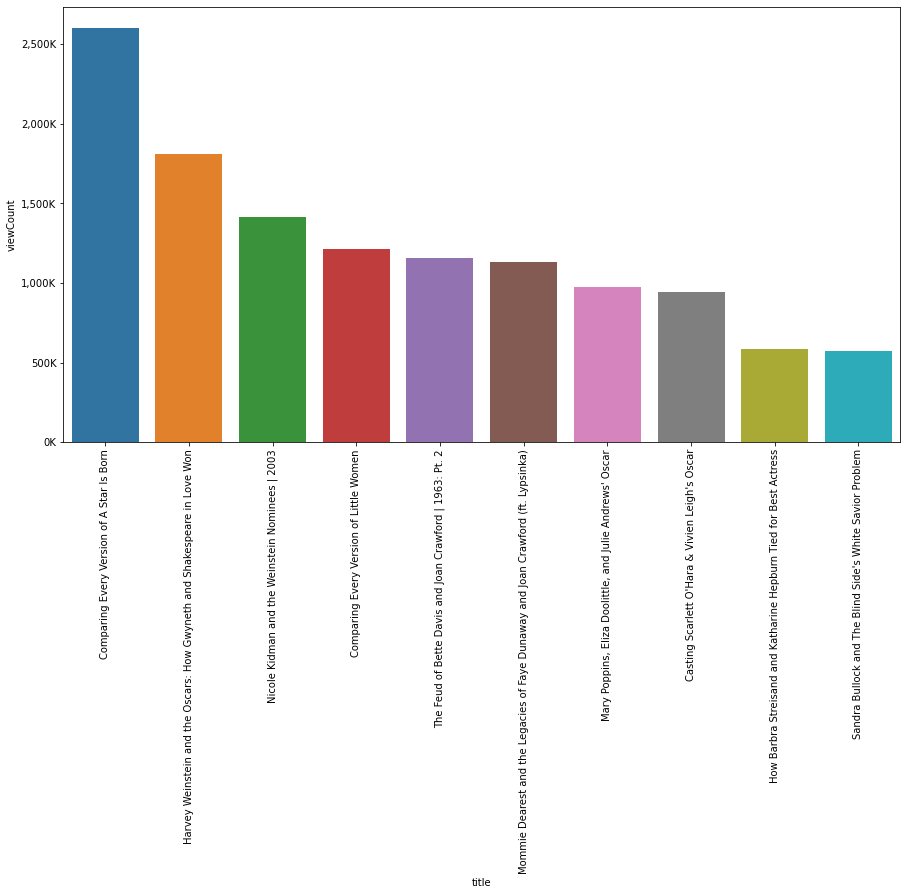

In [56]:
#The top performing videos by viewCount
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000)+'K'))

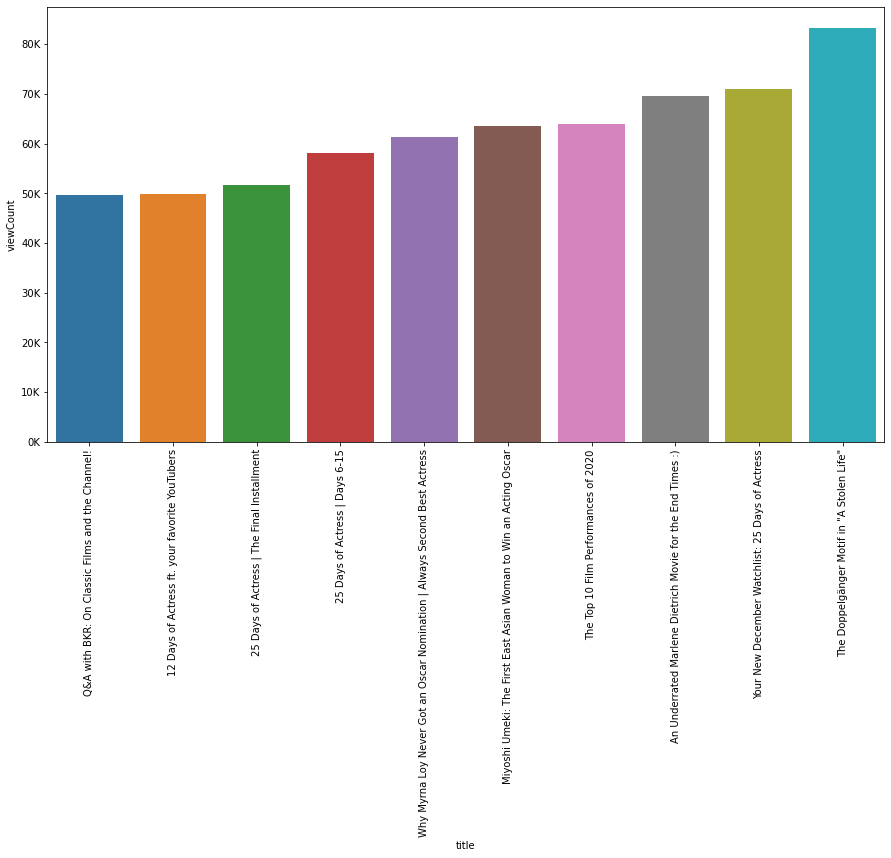

In [57]:
#Worst performing videos by vewCount:
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000)+'K'))

C:\Users\johni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

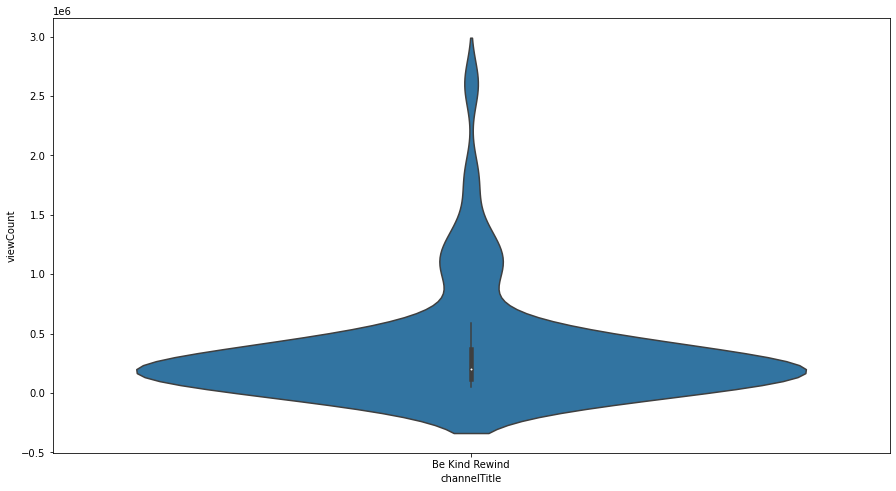

In [58]:
plt.figure(figsize = (15,8))
sns.violinplot(video_df['channelTitle'],video_df['viewCount'])

In [61]:
#average view count of videos
round(video_df['viewCount'].mean(),2)

352354.69

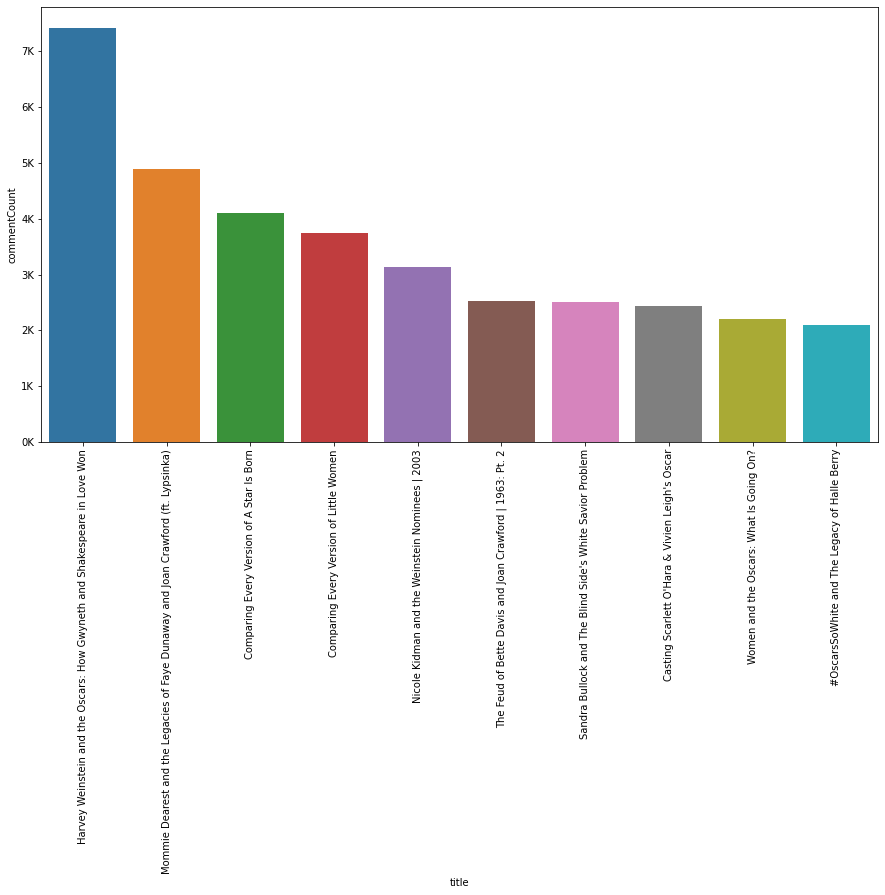

In [62]:
#Videos with most comments
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='commentCount', data = video_df.sort_values('commentCount', ascending=False)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000)+'K'))

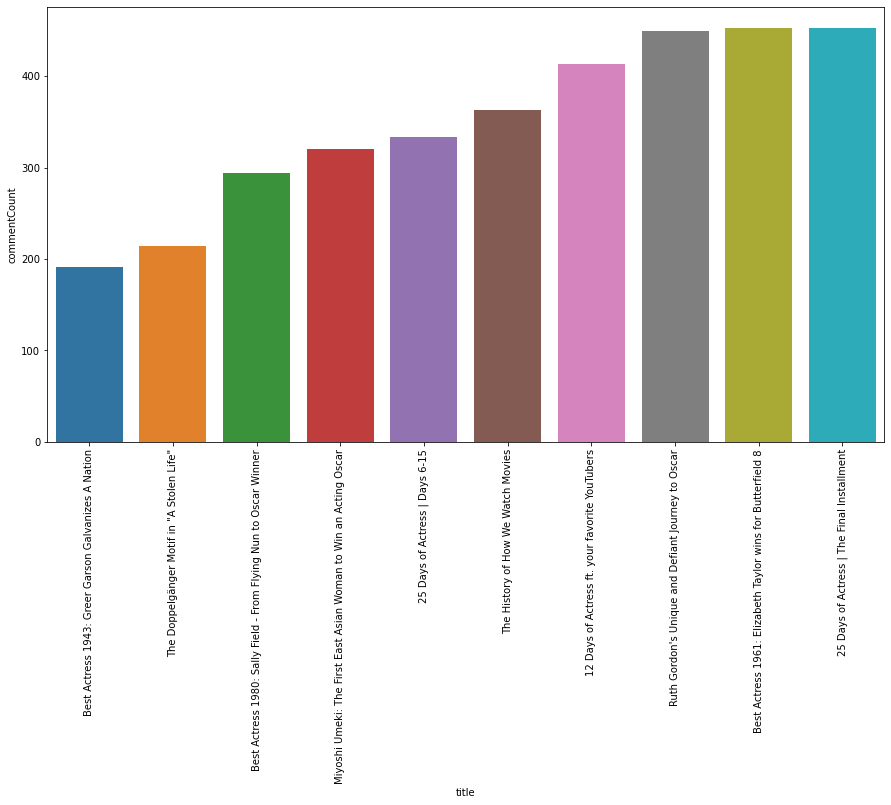

In [63]:
#least commented videos
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='commentCount', data = video_df.sort_values('commentCount', ascending=True)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

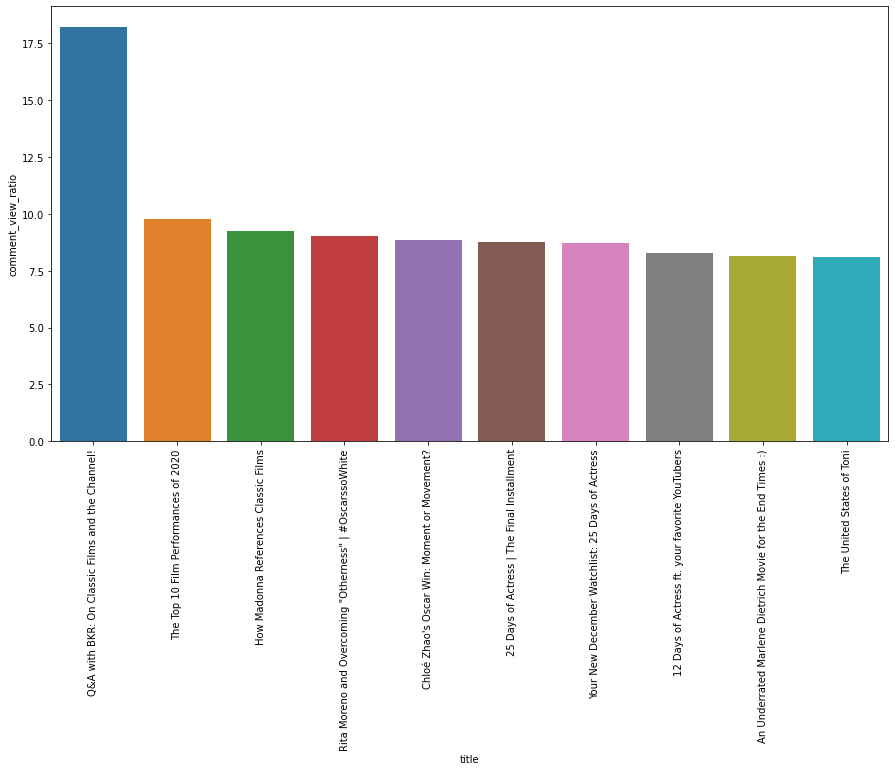

In [64]:
#video comments per 1000 views
video_df['comment_view_ratio'] = round((video_df['commentCount']/video_df['viewCount'])*1000,2)
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='comment_view_ratio', data = video_df.sort_values('comment_view_ratio', ascending=False)[0:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

C:\Users\johni\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='commentCount'>

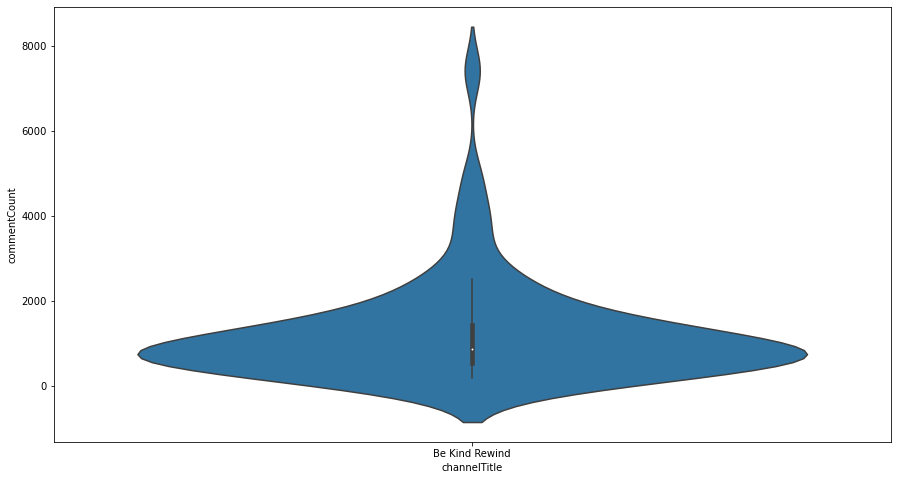

In [65]:
plt.figure(figsize = (15,8))
sns.violinplot(video_df['channelTitle'],video_df['commentCount'])

In [66]:
#average comments on videos
video_df['commentCount'].mean()

1246.4925373134329

In [67]:
#days of the week that videos are posted
video_publish_day_df = pd.DataFrame(video_df['dayPublished'].value_counts())
video_publish_day_df

,dayPublished
Tuesday,13
Monday,11
Sunday,11
Thursday,10
Friday,8
Saturday,8
Wednesday,6


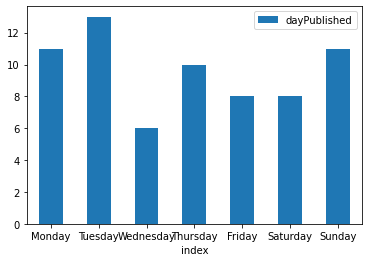

In [68]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
video_publish_day_df = video_publish_day_df.reindex(weekdays)
ax = video_publish_day_df.reset_index().plot.bar(x='index', y='dayPublished', rot=0)

In [69]:
#average duration of videos in minutes
round(video_df['durationSecs'].mean()/60,2)

23.13

<AxesSubplot:xlabel='durationSecs', ylabel='viewCount'>

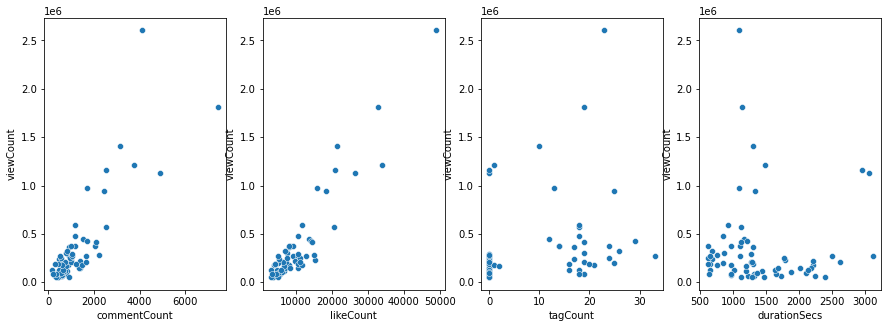

In [70]:
#check viewCount plotted against commentCount, likeCount, tagCount, durationSecs to see any striking patterns
fig, ax = plt.subplots(1,4, figsize=(15,5))
sns.scatterplot(data=video_df, x='commentCount', y='viewCount', ax = ax[0])
sns.scatterplot(data=video_df, x='likeCount', y='viewCount', ax = ax[1])
sns.scatterplot(data=video_df, x='tagCount', y='viewCount', ax= ax[2])
sns.scatterplot(data=video_df, x='durationSecs', y='viewCount', ax=ax[3])

In [71]:
#check the correalation of the different numerical variables
corr_matrix = video_df.corr()

In [72]:
corr_matrix

,viewCount,likeCount,commentCount,durationSecs,tagCount,comment_view_ratio
viewCount,1.000000,0.932727,0.842766,0.025714,0.287985,-0.385730
likeCount,0.932727,1.000000,0.876643,0.108549,0.130585,-0.255519
commentCount,0.842766,0.876643,1.000000,0.146403,0.100263,-0.120073
durationSecs,0.025714,0.108549,0.146403,1.000000,-0.621275,0.228176
tagCount,0.287985,0.130585,0.100263,-0.621275,1.000000,-0.589845
comment_view_ratio,-0.385730,-0.255519,-0.120073,0.228176,-0.589845,1.000000


<AxesSubplot:>

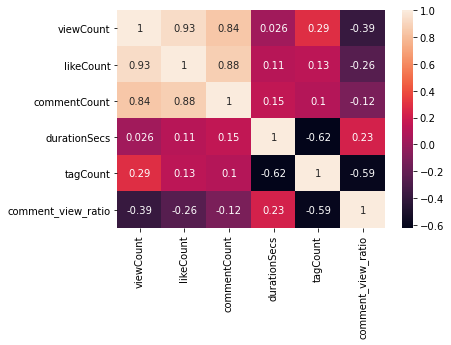

In [73]:
sns.heatmap(corr_matrix, annot=True)

<ipython-input-75-363268514558>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(xlabels)


[Text(0, 0.0, '0K'),
 Text(0, 1000000.0, '1,000K'),
 Text(0, 2000000.0, '2,000K'),
 Text(0, 3000000.0, '3,000K'),
 Text(0, 4000000.0, '4,000K'),
 Text(0, 5000000.0, '5,000K'),
 Text(0, 6000000.0, '6,000K')]

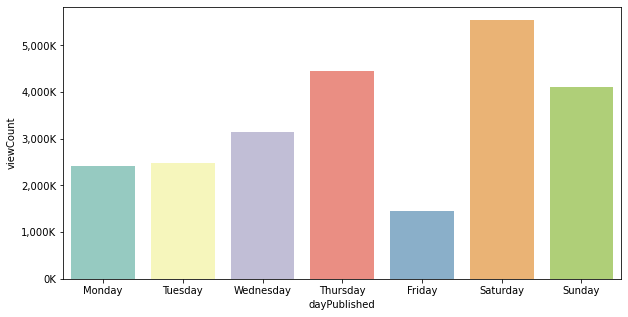

In [75]:
#videos grouped by the day of week theywere published and their current view counts
video_df['dayPublished'] = pd.Categorical(video_df['dayPublished'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

sns.set_palette("Set3")
fig, ax = plt.subplots(figsize=(10,5))
g= sns.barplot(data=video_df, x='dayPublished', y='viewCount', estimator=sum,ci=None)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(xlabels)

In [76]:
#day of the week when comments are posted
bkr_comments_eng['dayPublished'] = pd.Categorical(bkr_comments_eng['dayPublished'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                   ordered=True)

<ipython-input-76-5805152bc254>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkr_comments_eng['dayPublished'] = pd.Categorical(bkr_comments_eng['dayPublished'],


In [77]:
comments_publish_day_df = pd.DataFrame(bkr_comments_eng['dayPublished'].value_counts())
comments_publish_day_df

,dayPublished
Tuesday,10361
Sunday,10272
Monday,9759
Wednesday,9707
Friday,8976
Thursday,8819
Saturday,8603


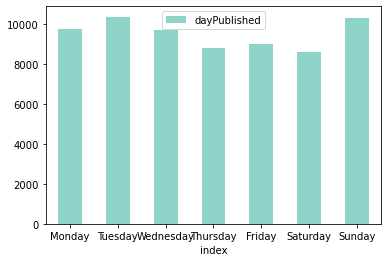

In [78]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
comments_publish_day_df = comments_publish_day_df.reindex(weekdays)
ax = comments_publish_day_df.reset_index().plot.bar(x='index', y='dayPublished', rot=0)

In [79]:
full_text=''.join(bkr_comments_final['clean_comments'])

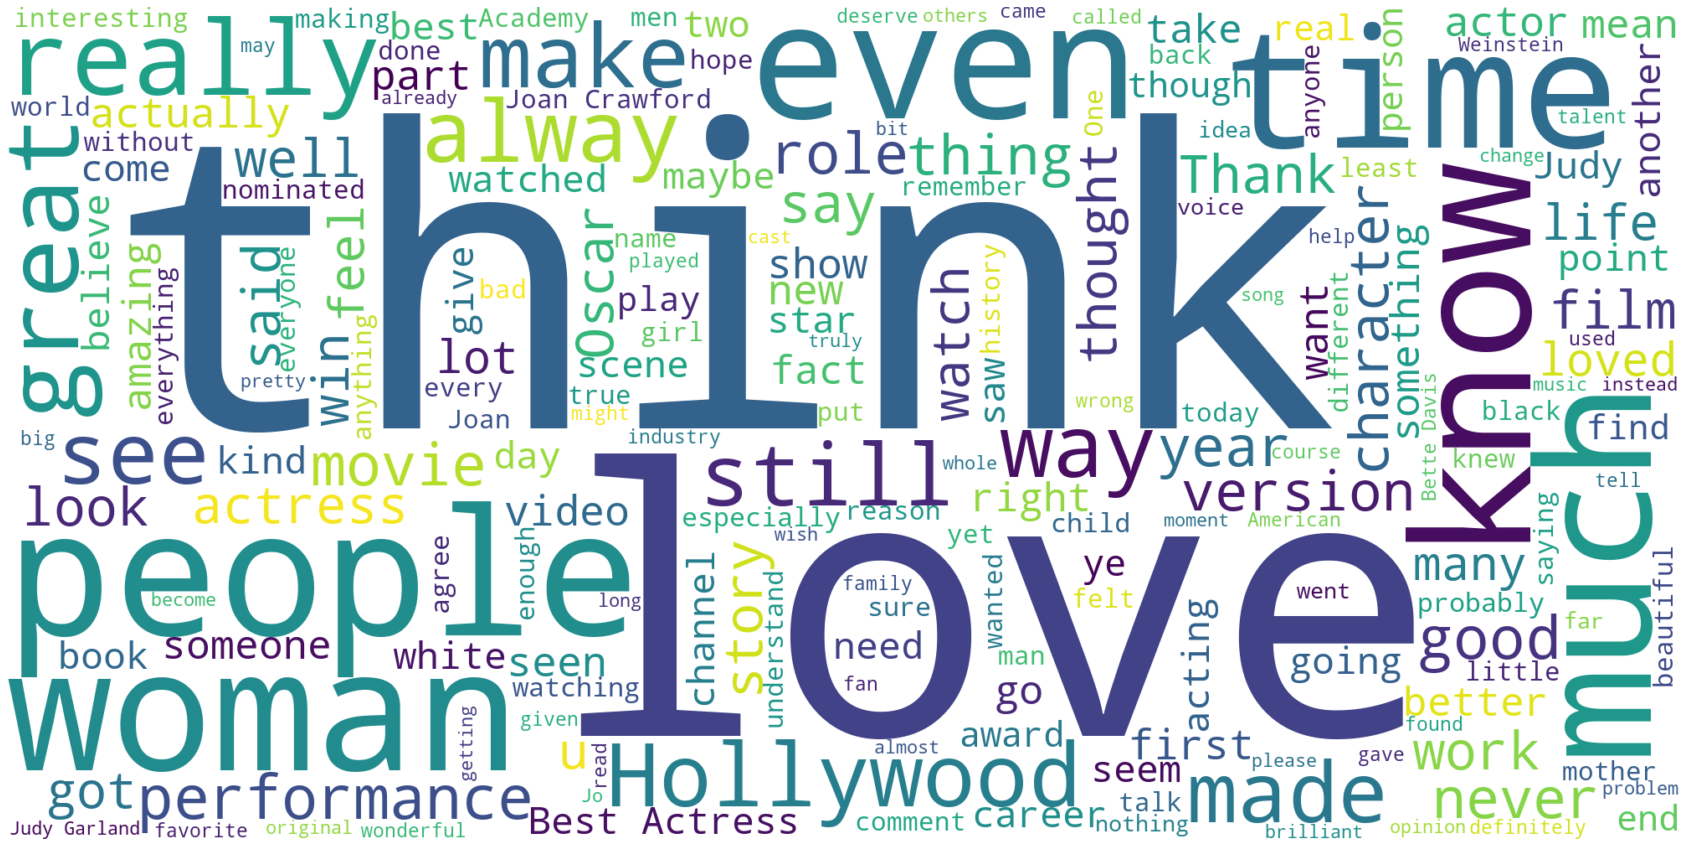

In [80]:
wc= WordCloud(width=2000, height=1000, background_color='white').generate(full_text)
plt.figure(figsize=(30,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

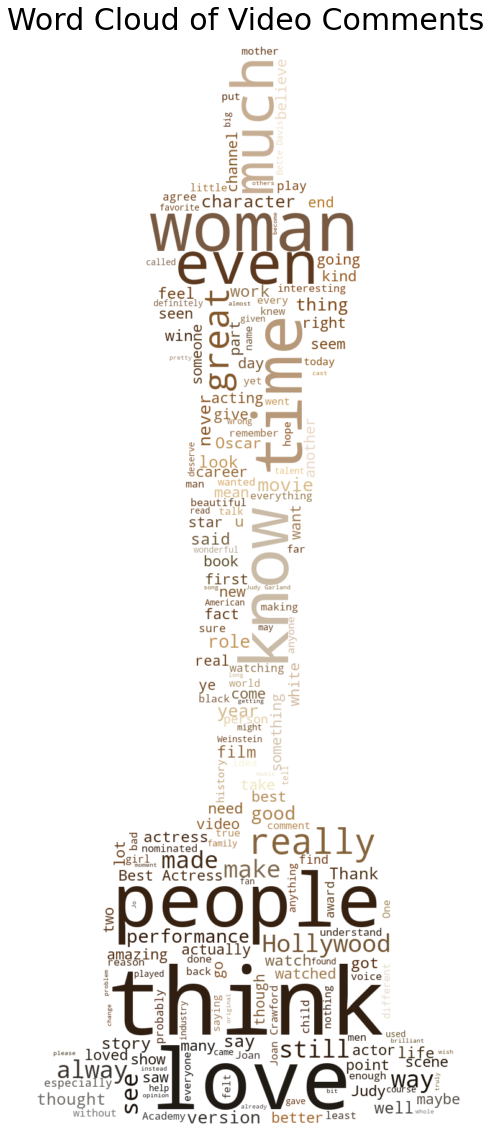

In [81]:
oscar_mask = np.array(Image.open('oscar.png'))
wc= WordCloud(background_color='white',random_state=94,mask=oscar_mask)
wc.generate(full_text)
plt.figure(figsize=(40,20))
image_colors = ImageColorGenerator(oscar_mask)
plt.title('Word Cloud of Video Comments', fontdict={'size':30, 'color':'black','verticalalignment':'bottom'})
plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()

#### 5. Sentiment Analysis 

In [82]:
# function to calculate subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
# function to calculate polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# function to analyze the reviews
def polarity_analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [83]:
bkr_comments_final['Subjectivity'] = bkr_comments_final['clean_comments'].apply(getSubjectivity)
bkr_comments_final['Polarity'] = bkr_comments_final['clean_comments'].apply(getPolarity)
bkr_comments_final['Sentiment'] = bkr_comments_final['Polarity'].apply(polarity_analysis)
bkr_comments_final

<ipython-input-83-bedf74295506>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkr_comments_final['Subjectivity'] = bkr_comments_final['clean_comments'].apply(getSubjectivity)
<ipython-input-83-bedf74295506>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkr_comments_final['Polarity'] = bkr_comments_final['clean_comments'].apply(getPolarity)
<ipython-input-83-bedf74295506>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,video_id,title,comments,likeCount,authorDisplayName,publishedAt,dayPublished,clean_comments,language,orig_num_words,clean_num_words,Subjectivity,Polarity,Sentiment
0,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,I’m looking from today’s perspective but even ...,0,Natalie DM,2022-05-04 11:09:57+00:00,Wednesday,I looking today perspective even actor get nom...,en,46,28,0.193333,0.146667,Positive
1,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,based Myrna,0,Pica hudsonia unflocked,2022-05-04 07:56:18+00:00,Wednesday,based Myrna,en,2,2,0.000000,0.000000,Neutral
2,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,ngl 11/10 would wanna see a modernized 13 Wome...,0,Pica hudsonia unflocked,2022-05-04 07:53:46+00:00,Wednesday,ngl would wanna see modernized Women properly ...,en,14,11,0.100000,0.000000,Neutral
3,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,"I just have to say this series is fantastic, I...",0,Bryony Claire,2022-05-04 07:00:02+00:00,Wednesday,I say series fantastic I adore deep dive amoun...,en,66,34,0.543750,0.068750,Positive
4,hY3B_sTrqeg,Why Myrna Loy Never Got an Oscar Nomination | ...,The problem is not (obviously) Myrna Loy's abi...,0,Marc Marco,2022-05-04 06:52:41+00:00,Wednesday,The problem obviously Myrna Loy ability actres...,en,127,63,0.430000,0.181538,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66492,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",The was a TV movie with Stefanie Powers called...,5,jhhone,2018-08-31 07:34:40+00:00,Friday,The TV Stefanie Powers called Deceptions much ...,en,29,15,0.300000,0.150000,Positive
66493,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",LOL! I've seen that. Doesn't she get blown up ...,3,Tom Ripley,2018-10-24 14:43:45+00:00,Wednesday,LOL I seen Doesn get blown yacht daring good time,en,19,10,0.650000,0.750000,Positive
66494,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",Like myself you must love miss Davis 'cause yo...,7,Elvis Ferreira,2018-07-04 05:35:37+00:00,Wednesday,Like must love miss Davis cause made whole Ple...,en,21,12,0.666667,0.400000,Positive
66495,DVWY6VyYvOQ,"The Doppelgänger Motif in ""A Stolen Life""",Oh The Dark Mirror released 1946 too. And Bett...,14,Elisha Hannah,2018-03-18 16:59:35+00:00,Sunday,Oh The Dark Mirror released And Bette Olivia f...,en,16,11,0.700000,0.175000,Positive


In [85]:
bkr_comments_final.to_csv("bkr_comments_with_sentiments.csv",index = False)

In [84]:
temp = pd.DataFrame(bkr_comments_final.groupby('Sentiment').count()['clean_comments'])
temp.style.background_gradient(cmap='Purples')

,clean_comments
Sentiment,
Negative,8810
Neutral,15440
Positive,42247


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

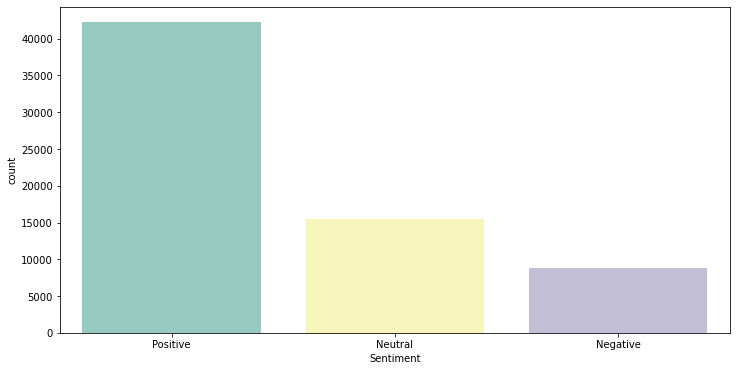

In [86]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=bkr_comments_final)

In [87]:
bkr_positive_comments = bkr_comments_final[bkr_comments_final['Sentiment']=='Positive']
bkr_neutral_comments = bkr_comments_final[bkr_comments_final['Sentiment']=='Neutral']
bkr_negative_comments = bkr_comments_final[bkr_comments_final['Sentiment']=='Negative']

In [88]:
def positive_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 120
    s = 80
    l = random_state.randint(10, 50) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def neutral_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 250
    s = 80
    l = random_state.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def negative_color_func(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 360
    s = 80
    l = random_state.randint(30, 70) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

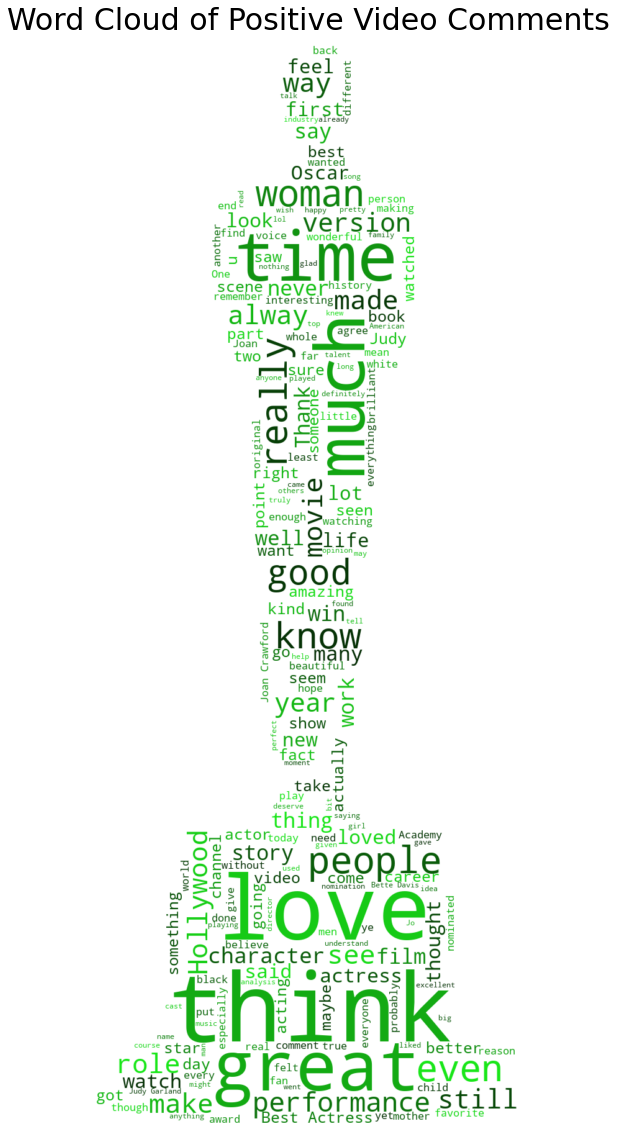

In [89]:
positive_text=''.join(bkr_positive_comments['clean_comments'])
oscar_mask = np.array(Image.open('oscar.png'))
wc= WordCloud(background_color='white',random_state=94,mask=oscar_mask, color_func=positive_color_func)
wc.generate(positive_text)
plt.figure(figsize=(40,20))
image_colors = ImageColorGenerator(oscar_mask)
plt.title('Word Cloud of Positive Video Comments', fontdict={'size':30, 'color':'black','verticalalignment':'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

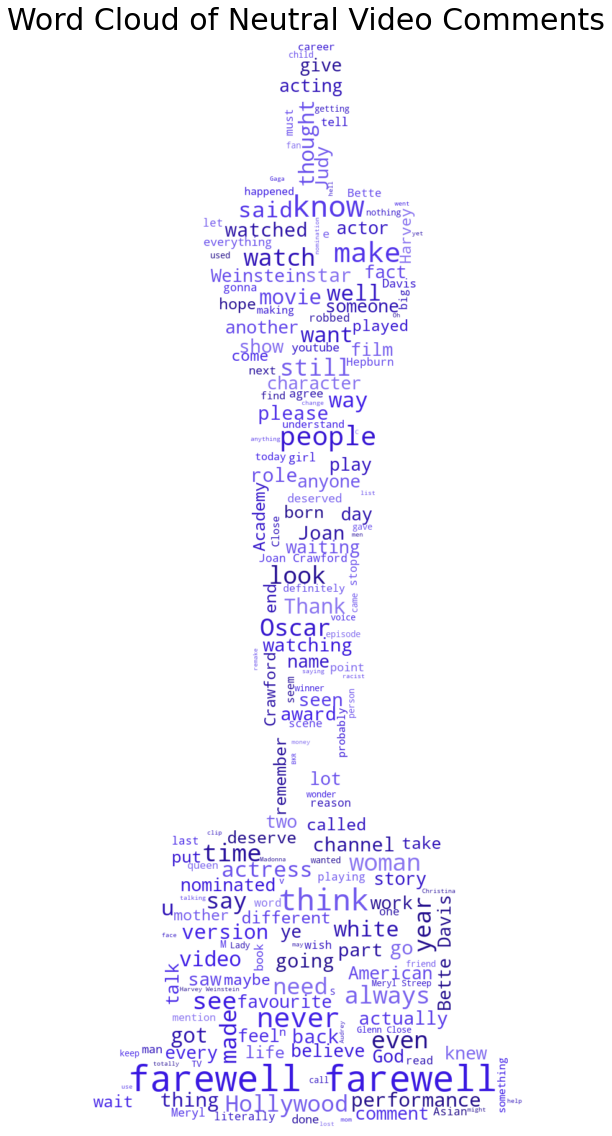

In [90]:
neutral_text=''.join(bkr_neutral_comments['clean_comments'])
oscar_mask = np.array(Image.open('oscar.png'))
wc= WordCloud(background_color='white',random_state=94,mask=oscar_mask, color_func=neutral_color_func)
wc.generate(neutral_text)
plt.figure(figsize=(40,20))
image_colors = ImageColorGenerator(oscar_mask)
plt.title('Word Cloud of Neutral Video Comments', fontdict={'size':30, 'color':'black','verticalalignment':'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

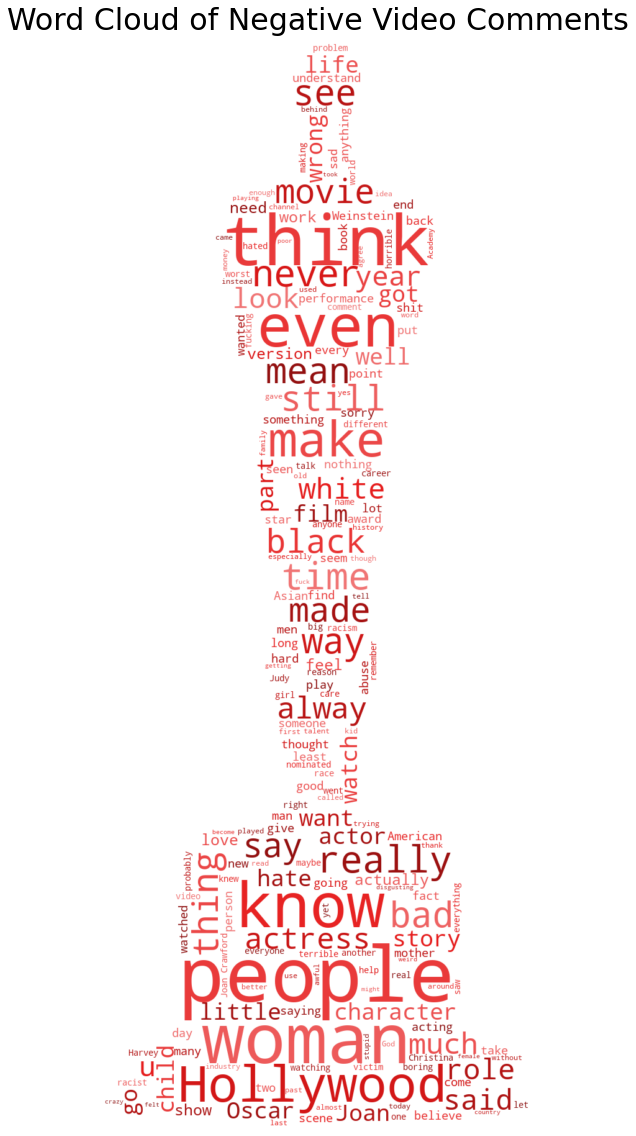

In [91]:
negative_text=''.join(bkr_negative_comments['clean_comments'])
oscar_mask = np.array(Image.open('oscar.png'))
wc= WordCloud(background_color='white',random_state=94,mask=oscar_mask,color_func=negative_color_func)
wc.generate(negative_text)
plt.figure(figsize=(40,20))
image_colors = ImageColorGenerator(oscar_mask)
plt.title('Word Cloud of Negative Video Comments', fontdict={'size':30, 'color':'black','verticalalignment':'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='clean_num_words', ylabel='Polarity'>

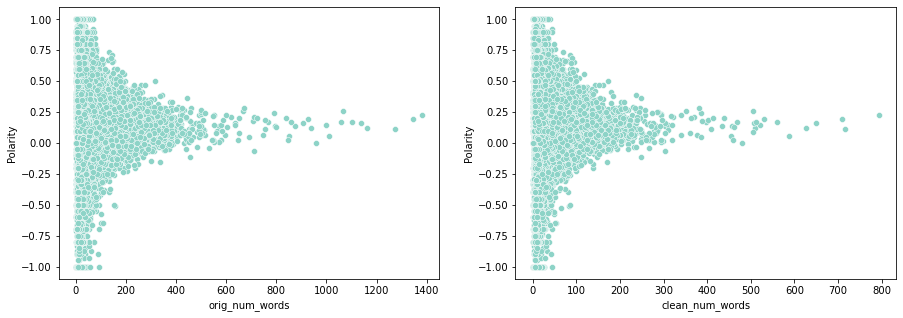

In [92]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=bkr_comments_final, x='orig_num_words', y='Polarity', ax = ax[0])
sns.scatterplot(data=bkr_comments_final, x='clean_num_words', y='Polarity', ax = ax[1])

<AxesSubplot:xlabel='clean_num_words', ylabel='Subjectivity'>

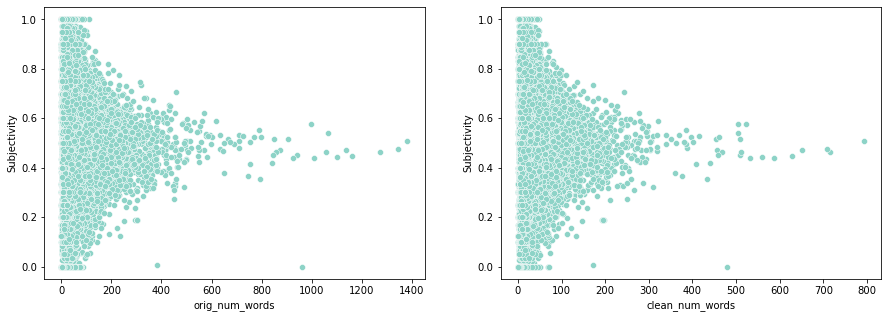

In [93]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=bkr_comments_final, x='orig_num_words', y='Subjectivity', ax = ax[0])
sns.scatterplot(data=bkr_comments_final, x='clean_num_words', y='Subjectivity', ax = ax[1])

In [94]:
video_sentiments_count = bkr_comments_final.groupby(['video_id','Sentiment'])['Sentiment'].count().to_frame('SentimentCount').reset_index()
video_sentiments_count

,video_id,Sentiment,SentimentCount
0,-5SRVg9CQFM,Negative,129
1,-5SRVg9CQFM,Neutral,337
2,-5SRVg9CQFM,Positive,927
3,-F_udvb6OCw,Negative,88
4,-F_udvb6OCw,Neutral,189
...,...,...,...
196,z4GvecFjLkU,Neutral,486
197,z4GvecFjLkU,Positive,1069
198,zDBXKP6L9iY,Negative,134
199,zDBXKP6L9iY,Neutral,232


In [95]:
video_sentiments =video_sentiments_count.groupby(['video_id'])['SentimentCount'].apply(list)
video_sentiments=pd.DataFrame(video_sentiments.apply(pd.Series)).reset_index()
video_sentiments.set_axis(['video_id','Negative', 'Neutral', 'Positive'], axis=1, inplace=True)
video_sentiments

,video_id,Negative,Neutral,Positive
0,-5SRVg9CQFM,129,337,927
1,-F_udvb6OCw,88,189,346
2,-eOb4cI-Pbo,64,93,295
3,0Gs-l6yHKHY,145,248,844
4,1aCgkHVUOgE,45,79,221
...,...,...,...,...
62,vwGsNPHvghU,142,196,831
63,wYwufGqkDP4,48,104,322
64,x1b1HkWF5VA,88,182,594
65,z4GvecFjLkU,373,486,1069


In [96]:
video_sentiments = pd.merge(video_sentiments, video_df[['video_id','title','commentCount']], on='video_id', how='left')
video_sentiments = video_sentiments[['video_id','title','Negative','Neutral','Positive']]
video_sentiments

,video_id,title,Negative,Neutral,Positive
0,-5SRVg9CQFM,The United States of Toni,129,337,927
1,-F_udvb6OCw,Best Actress 1973: Liza Minnelli wins for Cabaret,88,189,346
2,-eOb4cI-Pbo,Everything You Need to Know About Mank,64,93,295
3,0Gs-l6yHKHY,How Breakfast at Tiffany's Turned into a Total...,145,248,844
4,1aCgkHVUOgE,1936 | Bette Davis Wins A Consolation Oscar,45,79,221
...,...,...,...,...,...
62,vwGsNPHvghU,Comparing the film versions of West Side Story,142,196,831
63,wYwufGqkDP4,Movie Recs | What to Watch with Mrs. America,48,104,322
64,x1b1HkWF5VA,Joan Crawford Wins Best Actress For Mildred Pi...,88,182,594
65,z4GvecFjLkU,Nicole Kidman and the Weinstein Nominees | 2003,373,486,1069


In [97]:
video_sentiments['total_comments'] = video_sentiments['Negative']+video_sentiments['Neutral']+video_sentiments['Positive']
video_sentiments

,video_id,title,Negative,Neutral,Positive,total_comments
0,-5SRVg9CQFM,The United States of Toni,129,337,927,1393
1,-F_udvb6OCw,Best Actress 1973: Liza Minnelli wins for Cabaret,88,189,346,623
2,-eOb4cI-Pbo,Everything You Need to Know About Mank,64,93,295,452
3,0Gs-l6yHKHY,How Breakfast at Tiffany's Turned into a Total...,145,248,844,1237
4,1aCgkHVUOgE,1936 | Bette Davis Wins A Consolation Oscar,45,79,221,345
...,...,...,...,...,...,...
62,vwGsNPHvghU,Comparing the film versions of West Side Story,142,196,831,1169
63,wYwufGqkDP4,Movie Recs | What to Watch with Mrs. America,48,104,322,474
64,x1b1HkWF5VA,Joan Crawford Wins Best Actress For Mildred Pi...,88,182,594,864
65,z4GvecFjLkU,Nicole Kidman and the Weinstein Nominees | 2003,373,486,1069,1928


In [98]:
video_sentiments['Percentage_Negative'] = round((video_sentiments['Negative']/video_sentiments['total_comments'])*100,2)
video_sentiments['Percentage_Neutral'] = round((video_sentiments['Neutral']/video_sentiments['total_comments'])*100,2)
video_sentiments['Percentage_Positive'] = round((video_sentiments['Positive']/video_sentiments['total_comments'])*100,2)
video_sentiments

,video_id,title,Negative,Neutral,Positive,total_comments,Percentage_Negative,Percentage_Neutral,Percentage_Positive
0,-5SRVg9CQFM,The United States of Toni,129,337,927,1393,9.26,24.19,66.55
1,-F_udvb6OCw,Best Actress 1973: Liza Minnelli wins for Cabaret,88,189,346,623,14.13,30.34,55.54
2,-eOb4cI-Pbo,Everything You Need to Know About Mank,64,93,295,452,14.16,20.58,65.27
3,0Gs-l6yHKHY,How Breakfast at Tiffany's Turned into a Total...,145,248,844,1237,11.72,20.05,68.23
4,1aCgkHVUOgE,1936 | Bette Davis Wins A Consolation Oscar,45,79,221,345,13.04,22.90,64.06
...,...,...,...,...,...,...,...,...,...
62,vwGsNPHvghU,Comparing the film versions of West Side Story,142,196,831,1169,12.15,16.77,71.09
63,wYwufGqkDP4,Movie Recs | What to Watch with Mrs. America,48,104,322,474,10.13,21.94,67.93
64,x1b1HkWF5VA,Joan Crawford Wins Best Actress For Mildred Pi...,88,182,594,864,10.19,21.06,68.75
65,z4GvecFjLkU,Nicole Kidman and the Weinstein Nominees | 2003,373,486,1069,1928,19.35,25.21,55.45


In [99]:
video_sentiments.to_csv('video_sentiments.csv', index=False)

In [100]:
print('Total positive comments: '+str(sum(video_sentiments['Positive'])))
print('Total neutral comments: '+str(sum(video_sentiments['Neutral'])))
print('Total negative comments: '+str(sum(video_sentiments['Negative'])))

Total positive comments: 42247
Total neutral comments: 15440
Total negative comments: 8810


In [101]:
print('Percentage of positive comments: '+str(round((sum(video_sentiments['Positive'])/bkr_comments_final['Sentiment'].count())*100,2))+'%')
print('Percentage of neutral comments: '+str(round((sum(video_sentiments['Neutral'])/bkr_comments_final['Sentiment'].count())*100,2))+'%')
print('Percentage of negative comments: '+str(round((sum(video_sentiments['Negative'])/bkr_comments_final['Sentiment'].count())*100,2))+'%')

Percentage of positive comments: 63.53%
Percentage of neutral comments: 23.22%
Percentage of negative comments: 13.25%


In [102]:
bkr_comments_final['Sentiment']

0        Positive
1         Neutral
2         Neutral
3        Positive
4        Positive
           ...   
66492    Positive
66493    Positive
66494    Positive
66495    Positive
66496    Positive
Name: Sentiment, Length: 66497, dtype: object

(0.0, 100.0)

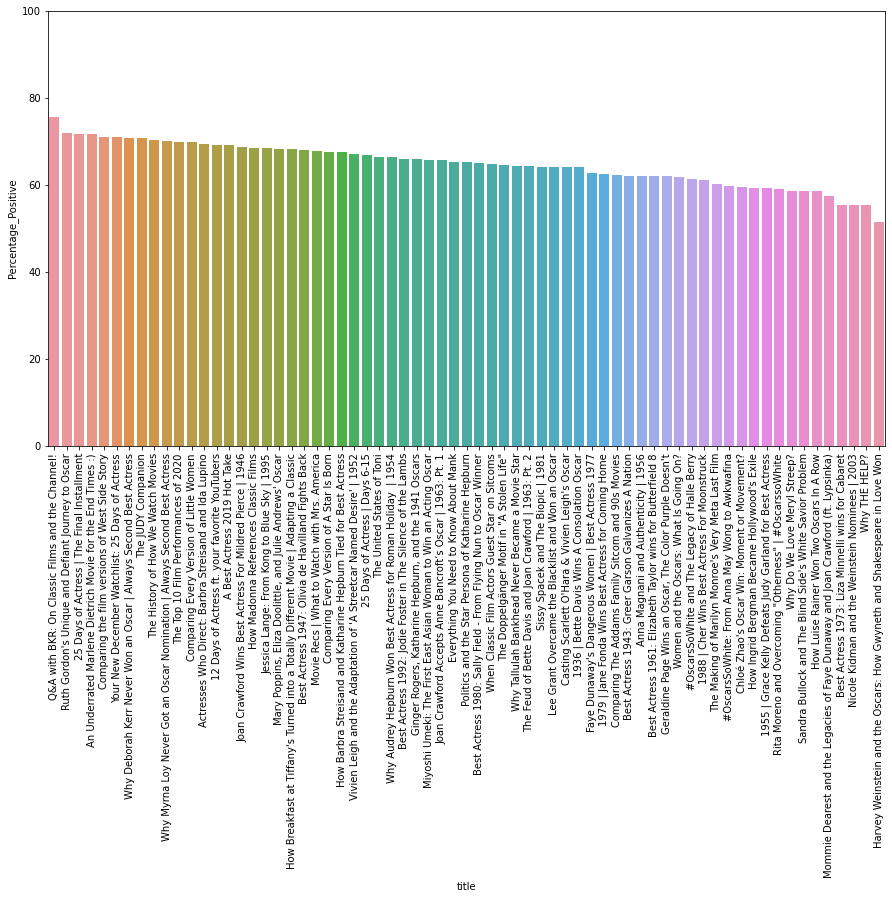

In [103]:
#Highest percentage of positive comments
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='Percentage_Positive', data = video_sentiments.sort_values('Percentage_Positive', ascending=False))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim([0, 100])

(0.0, 100.0)

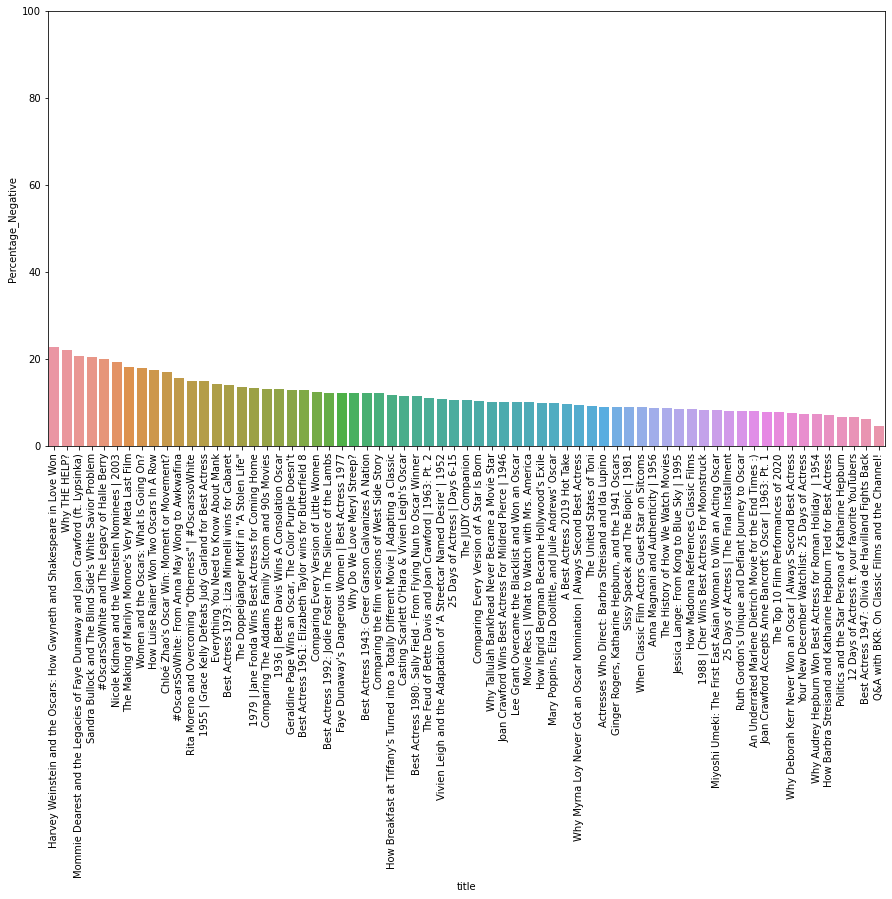

In [104]:
#Highest percentage of negative comments
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='Percentage_Negative', data = video_sentiments.sort_values('Percentage_Negative', ascending=False))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim([0, 100])

(0.0, 100.0)

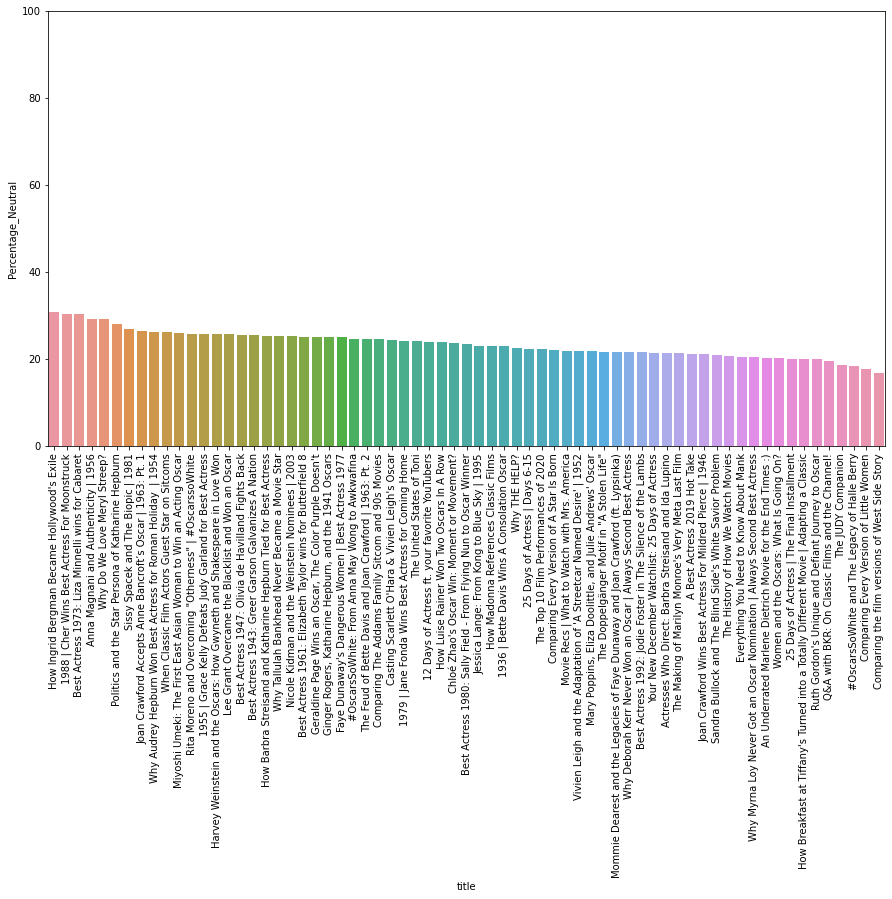

In [105]:
#Highest percentage of neutral comments
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'title', y='Percentage_Neutral', data = video_sentiments.sort_values('Percentage_Neutral', ascending=False))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim([0, 100])

#### 6. Conclusion